In [5]:
# %pip install seaborn
# %pip install sklearn
from glob import glob
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from sklearn.metrics import mean_squared_error, accuracy_score

In [13]:
# paths
base_dir = "/workspace/C684_Assignment/"
processing_dir = os.path.join(base_dir, "processing")

# utility functions
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true': Y_true,' Y_pred': Y_pred})
            score_mat = Res[['Y_true', 'Y_pred']].corr(method='spearman', min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii], Y_true[:,ii])

### Load the ground truth values

In [11]:
labels = pd.read_csv("/workspace/C684_Assignment/Dev-set/Ground-truth/ground-truth.csv")
display(labels)

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10
...,...,...,...,...,...
5995,video7488.webm,0.921,33,1.000,9
5996,video7489.webm,0.909,53,0.839,31
5997,video7491.webm,0.713,33,0.818,11
5998,video7492.webm,0.954,34,1.000,16


### Process all amnet_pred_*.csv files
Note: These files were output by AMNet for each frame while producing the attention map triplet

##### Step 1: Concatenate

In [10]:
columns = ["video", "Y_pred"]
per_frame_preds = pd.DataFrame(columns=columns)
pred_glob = glob(os.path.join("/workspace/C684_Assignment/processing/amnet_pred_*.csv"))
for each_file in pred_glob:
    frame_batch_preds = pd.read_csv(each_file, ' ', names=["video", "Y_pred", "_1", "_2"], usecols=columns)
    frame_batch_preds["video"] = frame_batch_preds["video"].str.replace(".*/(.+)?\.jpg", lambda m: m.group(1))
    per_frame_preds = per_frame_preds.append(frame_batch_preds, ignore_index=True)
per_frame_preds.to_csv("/workspace/C684_Assignment/processing/all_amnet_pred.csv")

<ipython-input-10-33534bfe678e>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  frame_batch_preds["video"] = frame_batch_preds["video"].str.replace(".*/(.+)?\.jpg", lambda m: m.group(1))


##### Step 2: Calculate AMNet prediction per video (mean across each 28 frames) 

In [ ]:
per_frame_preds["video"] = per_frame_preds["video"].str.replace("(.+)?_.*", lambda m: m.group(1) + ".webm")
preds = per_frame_preds.groupby("video", as_index=False)["Y_pred"].mean()

##### Step 3: Eliminate the test videos (for whcih ground truth is not provided)

In [ ]:
devset_preds = preds.merge(labels, how="inner", on="video")
devset_preds["video"] = devset_preds["video"].str.replace(".webm", "")
display(devset_preds)
devset_preds.to_csv("/workspace/C684_Assignment/processing/amnet_devset_preds.csv")

##### Step 4: Train/test split and persist for consistency when training

In [ ]:
df = pd.read_csv(os.path.join(processing_dir, "amnet_devset_preds.csv"))
df_train, df_test = train_test_split(df, test_size=0.15)
df_train["test"] = False
df_test["test"] = True
df = pd.concat([df_train, df_test])
df.to_csv(os.path.join(processing_dir, "amnet_devset_preds.csv"))

##### Step 5: Plot AMNet's own prediction against ground truth (short- and long-term)

The Spearman's correlation coefficient is: 0.4183
The MSE is: 0.0194


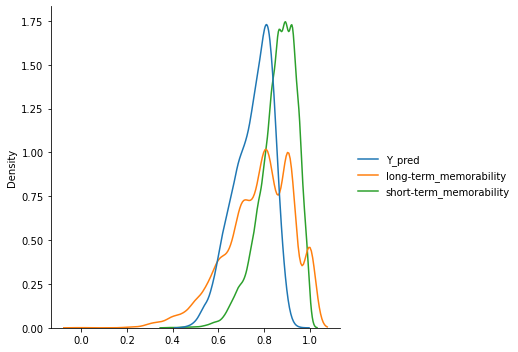

In [16]:
devset_preds = pd.read_csv(os.path.join(processing_dir, "amnet_devset_preds.csv"))
sns.displot(data=[devset_preds["Y_pred"], labels["long-term_memorability"], labels["short-term_memorability"]], kind="kde")
X = devset_preds["Y_pred"].to_numpy().reshape(-1, 1)
y = devset_preds["short-term_memorability"].to_numpy().reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9)
Res = pd.DataFrame()
Res["Y_true"] = devset_preds["short-term_memorability"]
Res["Y_pred"] = devset_preds["Y_pred"]
score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
print("The Spearman\'s correlation coefficient is: %.4f" % score_mat.iloc[1][0])
mse = mean_squared_error(Res["Y_true"], Res["Y_pred"])
print("The MSE is: %.4f" % mse)